# Proteína ERK2: 
## Obtención de Metadatos del PDB
Genera un archivo con los metadatos depositados con cada estructura cristalográfica de la proteína de interés.

In [3]:
# Librerías
import pypdb
import pandas as pd
import numpy as np
import csv
import pickle
from prody import *
from Bio import pairwise2, SeqIO
import sys
# Añadimos la ruta del directorio raíz para tener acceso a los archivos y módulos
sys.path.append(r'..')

## Secuencia de la proteína
Se define el nombre de la proteína y su identificador en UNIPROT:

In [4]:
# Nombre de la proteina de interes
prot_name = 'erk2'
# Secuencia P28482 (ERK2_HUMAN)
uniprot_id = "P28482"

Los metadatos se generan a partir de la lista de PDB IDs obtenida con un BLASTp a partir de la secuencia query utilizada. Un archivo que guarda los datos del blast es leido y de él se carga la lista de PDB IDs.

In [5]:
# Secuencia de la ERK2 de UniProt
fasta = SeqIO.read(open(F'../data/{uniprot_id}.fasta'),'fasta')
seq_prot = str(fasta.seq)
print(seq_prot)

MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS


In [6]:
# Cargo los datos del alineamiento hecho con PRODY en el archivo Descarga_PDBs_CDK2.ipynb
blast_record = pickle.load(open(F'../data/{prot_name}_blast_record.pkl', 'rb'))
pdbids = blast_record.getHits(percent_identity=95) # Devuelve un diccionario con cada proteína hit
print(len(pdbids), "proteínas tienen un 95% de identidad con la secuencia de UNIPROT.") 
# 408 proteínas tienen un 95% de identidad con la secuencia de UNIPROT
# Lista de PDB IDs
pdbids_list = list(pdbids.keys()) # lista de pdb_ids de las estructuras de CDK2

166 proteínas tienen un 95% de identidad con la secuencia de UNIPROT.


In [7]:
pdbids_list[0:5]

['2y9q', '4fmq', '4nif', '4qta', '4qte']

### NOTA:
**Tener en cuenta que *pdbids_list* y *pdbids* están ordenados por su valor de identidad y no por orden alfabético.**  
Sin embargo, a partir de la creación de la tabla de metadatos y el modelado de las estructuras, los datos y archivos estarán ordenados por orden alfanumérico.

### PDB_list es ordenada alfanuméricamente

In [8]:
pdbids_list.sort() # Lista ordenada alfanuméricamente
pdbids_list[0:5]

['1erk', '1gol', '1pme', '1tvo', '1wzy']

### Funciones extra
Se emplean las siguientes dos funciones para obtener alineamientos correctos de la secuencia del pdb en relación con la secuencia de uniprot, y saber así el valor de covertura y el número de gaps en la estructura. Ambas funciones están guardadas en el directorio **modulos**.

In [9]:
# Versión marzo 2018 *Anotar las modificaciones en esta versión y comentar lo pasado
from modules.get_seq_data import get_data
# Recibe una secuencia (con gaps como "-") y un valor r para valorar el gap en +/- r posiciones 
# Genera un alineamiento  partir de una estructura PDB y una secuencia de aminoácidos.

***
## Descarga de los metadatos de los cristales
Para descargar los metadatos de los pdbs y posteriormente guardarlos en un archivo.  
Para ello se itera la lista de PDB IDs y se guardan los datos en un diccionario.

### NOTA:
**Justo antes de iniciar el loop *pdbids_list* debió haber sido ordenada.**

In [ ]:
prot_crys_mtd = {} # Diccionario temporal para posteriormente guardar en un archivo de texto
import time
start = time.time()

# ¿Está ordenada alfanuméricamente?
print("¿Está la lista ordenada?: ", pdbids_list[0:5])

# Primero se crea el diccionario
for pdb in pdbids_list:
    try:
        '''Para obtener los metadatos de todos los cristales'''
        descrip_pdb = pypdb.describe_pdb(pdb)
        cristal = pypdb.get_entity_info(pdb)
        ligando = pypdb.get_ligands(pdb)['ligandInfo']
        secuencia = pdbids[pdb]
        seq_alg, covertura, gaps = get_data(pdb, seq_prot,
                                            struct_dir = F'../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_CHAINS/', 
                                            tail_pdb = '_A.pdb')
        if ligando != None:
            ligando = ligando['ligand']
            if isinstance(ligando, dict): 
                # Si me devuelve un dict significa que sólo hay un lig
                ligando = [ligando] # Anida el dict a una lista, tal como
                # ocurre cuando hay más de un ligando
            num_ligs = len(ligando)
            # Lista del nombre de los ligandos
            ligs_names = [ligando[mol]['@chemicalID'] for mol in range(num_ligs)]
        else:
            ligs_names = []
            num_ligs = 0
        prot_crys_mtd.update({pdb : {'describe_pdb': descrip_pdb, 'pdb_info': cristal, 'ligs': ligando, 
                                     'num_ligs': num_ligs, 'name_ligs': ligs_names,'seq': secuencia,
                                     'seq_alg': seq_alg, 'covertura': covertura, 'gaps': gaps}})
    except Exception as e:
        print(str(e) + ": Error con " + pdb)
# Finalmente el diccionario generado posee un diccionario para cada clave pdb,
# que, a su vez, posee cinco entradas: pdb_info, ligs, ligs_names, num_ligs, seq
    
end = time.time()
print(end - start)
print(len(prot_crys_mtd))

# Creación de la tabla de metadatos
### Para guardar y leer el archivo de metadatos

Para este punto se han descargado todos los cristales disponibles de la proteína, incluyendo sus metadatos.

In [14]:
## GUARDAR
# Versión JSON
import json
n_pdb_id = len(pdbids_list)
#json.dump(prot_crys_mtd, open(F"../data/MTDATA_{prot_name.upper()}_{str(n_pdb_id)}_crys.json",'w'))

## LEER el archivo json creado
prot_crys_mtd = json.load(open(F"../data/MTDATA_{prot_name.upper()}_{len(pdbids_list)}_crys.json", 'r'))


### Funciones para generar la tabla de datos

In [15]:
# PDB_ID, Título, #Entidades, #Cadenas, Cadena, Covertura, #Gaps, ListaGaps, #residuos, Resulucion, método, #Ligs, IDs Ligs, 
# Nombres Ligs, Lig más grande, Peso Lig más grande
def get_data_rows(pdb_entry):
    x = pdb_entry
    d = x['describe_pdb']
    s = x['seq']
    l = x['ligs']

    dic = {"PDB_ID": d['structureId'].lower(),
          "Title": d['title'].lower(),
          "Entities": d['nr_entities'],
          "ChainID": s['chain_id'],
          "Identity": s['identity'],
          "Coverage": x['covertura'],
          "NumGaps": x['gaps']['num_gaps'],
          "GapLen": x['gaps']['gap_lengths'],
          "GapPos": x['gaps']['gap_list'],
          #"NumResidues": ,
          "Resolution": d['resolution'],
          "Date": d['release_date'],
          "NumLigs": x['num_ligs'], 
          "NameLigs": x['name_ligs'],
          }
    return(pd.Series(dic))

def get_mtd_table(dic):
    df = pd.DataFrame()
    for pdb_id in dic.keys():
        row = get_data_rows(dic[pdb_id])
        df = df.append(row, ignore_index=True)
    return(df)

***
<br>

### Se genera, ORDENA y se descartan los PDBIs necesarios del DataFrame
Se crea la tabla de los metadatos con el número de estructuras correspondientes a todos los PDB ids.

In [16]:
# Se genera el dataframe
df_prot = get_mtd_table(prot_crys_mtd).sort_values("PDB_ID")
print("La tabla de datos tiene registradas", str(len(df_prot)), "estructuras.")

# Removemos las estructuras que no servirán para continuar el análisis
# Estas sestructuras son identificadas en el paso de modelación con Modeller
# con lo cual la lista debe ser actualizada si se identifican estructuras que no puedan ser modeladas
droped_pdb_ids = []

df_prot = df_prot.loc[ ~df_prot["PDB_ID"].isin(droped_pdb_ids) ]
print("La NUEVA tabla de datos tiene registradas", str(len(df_prot)), "estructuras.")

# Reordenando la tabla
df_prot = df_prot.reset_index()

# Se reordenan las columnas
df_prot = df_prot[['PDB_ID', 'Title','Date', 'Entities', 'ChainID','Resolution', 
         'Identity', 'Coverage', 'NumGaps', 'GapLen', 'GapPos',
         'NumLigs', 'NameLigs']]

La tabla de datos tiene registradas 166 estructuras.
La NUEVA tabla de datos tiene registradas 166 estructuras.


In [17]:
df_prot.tail(10)

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
156,6q7s,erk2 mini-fragment binding,2019-06-26,1,A,1.73,359.0,94.722222,4.0,"[10, 1, 4, 4]","[[1, 10], [161, 161], [330, 333], [357, 360]]",3.0,"[CME, IPH, SO4]"
157,6q7t,erk2 mini-fragment binding,2019-06-26,1,A,1.60,359.0,94.166667,4.0,"[10, 1, 6, 4]","[[1, 10], [161, 161], [330, 335], [357, 360]]",3.0,"[CME, HOW, SO4]"
158,6qa1,erk2 mini-fragment binding,2019-06-26,1,A,1.58,359.0,94.722222,4.0,"[10, 1, 6, 2]","[[1, 10], [161, 161], [331, 336], [359, 360]]",3.0,"[CME, HVK, SO4]"
159,6qa3,erk2 mini-fragment binding,2019-06-26,1,A,1.57,359.0,94.722222,4.0,"[7, 1, 8, 3]","[[1, 7], [161, 161], [330, 337], [358, 360]]",3.0,"[CME, PZO, SO4]"
160,6qa4,erk2 mini-fragment binding,2019-06-26,1,A,1.60,359.0,93.333333,5.0,"[10, 2, 1, 8, 3]","[[1, 10], [35, 36], [161, 161], [331, 338], [3...",3.0,"[CME, HRZ, SO4]"
161,6qag,erk2 mini-fragment binding,2019-03-27,1,A,2.07,359.0,94.166667,4.0,"[10, 1, 7, 3]","[[1, 10], [161, 161], [331, 337], [358, 360]]",3.0,"[CME, HUH, SO4]"
162,6qah,erk2 mini-fragment binding,2019-06-26,1,A,1.58,359.0,94.166667,5.0,"[10, 1, 1, 6, 3]","[[1, 10], [36, 36], [161, 161], [332, 337], [3...",3.0,"[CME, HVB, SO4]"
163,6qal,erk2 mini-fragment binding,2019-03-27,1,A,1.57,359.0,93.055556,5.0,"[10, 3, 1, 8, 3]","[[1, 10], [34, 36], [161, 161], [331, 338], [3...",3.0,"[CME, HV2, SO4]"
164,6qaq,erk2 mini-fragment binding,2019-03-27,1,A,1.58,359.0,95.277778,4.0,"[10, 1, 3, 3]","[[1, 10], [161, 161], [331, 333], [358, 360]]",3.0,"[CME, HVQ, SO4]"
165,6qaw,erk2 mini-fragment binding,2019-03-27,1,A,1.84,358.0,93.333333,5.0,"[10, 1, 1, 9, 3]","[[1, 10], [127, 127], [161, 161], [330, 338], ...",3.0,"[CME, HVE, SO4]"


In [18]:
# Lista de columnas del dataframe
', '.join( df_prot.columns.tolist() )

'PDB_ID, Title, Date, Entities, ChainID, Resolution, Identity, Coverage, NumGaps, GapLen, GapPos, NumLigs, NameLigs'

### Se guarda la tabla en archivo json

In [19]:
n_pdb_id_to_use = len(df_prot)
df_prot.to_json(F"../data/TABLA_MTDATA_{prot_name.upper()}_{str(n_pdb_id_to_use)}_crys.json")

## Nube de palabras de los títulos de metadatos

In [46]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

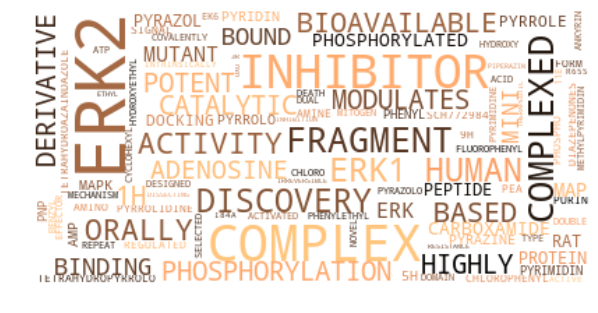

In [48]:
text = " ".join(titulo for titulo in df_prot.Title)
text = text.replace('-', ' ').upper()

stopwords = set(STOPWORDS)
stopwords.update([ "structure", "kinase", "ray", "crystal", "yl"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, collocations=False, min_font_size=4,
                      contour_width=20, colormap = "copper", random_state=15,
                      max_words=100, background_color="white").generate(text)

plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()